# TP noté no 2 : Bagging, Boosting, Random Forests

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from IPython.display import display, Math
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from multiprocessing import Pool
from sklearn.preprocessing import scale
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.datasets import load_iris, load_boston, load_diabetes, load_digits
from sklearn.base import ClassifierMixin, clone
from numpy.random import choice

%matplotlib inline

In [2]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
n_estimators = 10 # L in the text
tree_max_depth = 10
bagging_max_depth = 10

colors = list(cnames.keys())

x_tr, x_te, y_tr, y_te = train_test_split(X, y)

## BAGGING

### 1) Mettez en œuvre le Bagging avec des arbres de profondeur 1 (en Anglais stumps), puis avec des arbres plus profonds, en partant du code ci-dessous. On pourra utiliser BaggingRegressor.

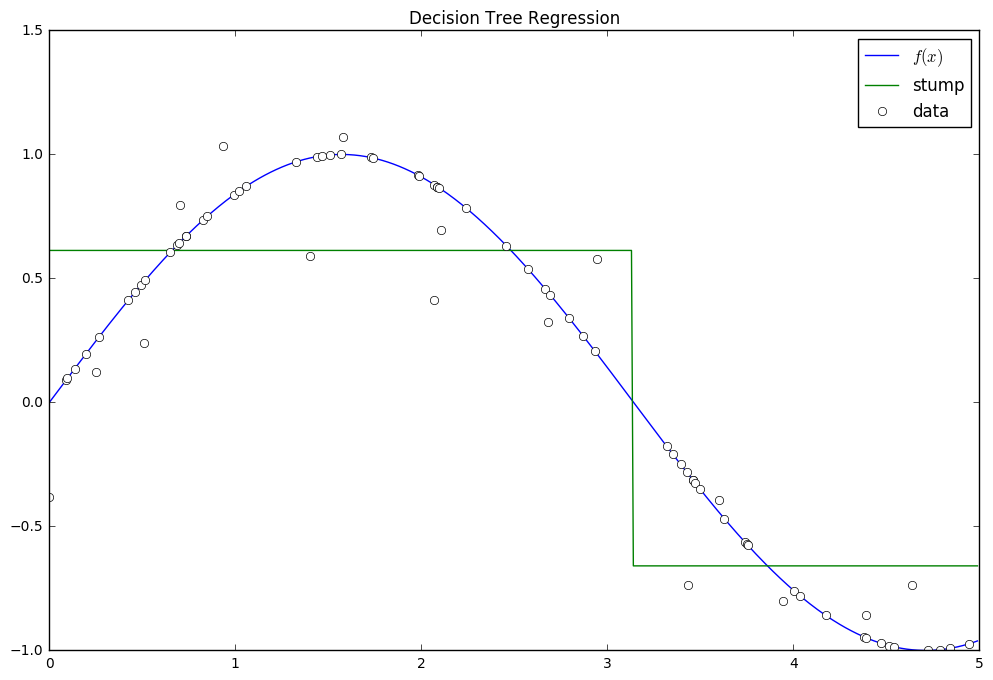

In [3]:
stump = DecisionTreeRegressor(max_depth=1)
stump.fit(X, y)
y_stump = stump.predict(X_test)

plt.figure(figsize=(12, 8))
plt.plot(X_test, np.sin(X_test).ravel(), "b", label="$f(x)$")
plt.plot(X_test, y_stump, c="g", label="stump")
plt.plot(X, y, 'o', c="w", label="data")
plt.title("Decision Tree Regression")
plt.legend(loc=1, numpoints=1)

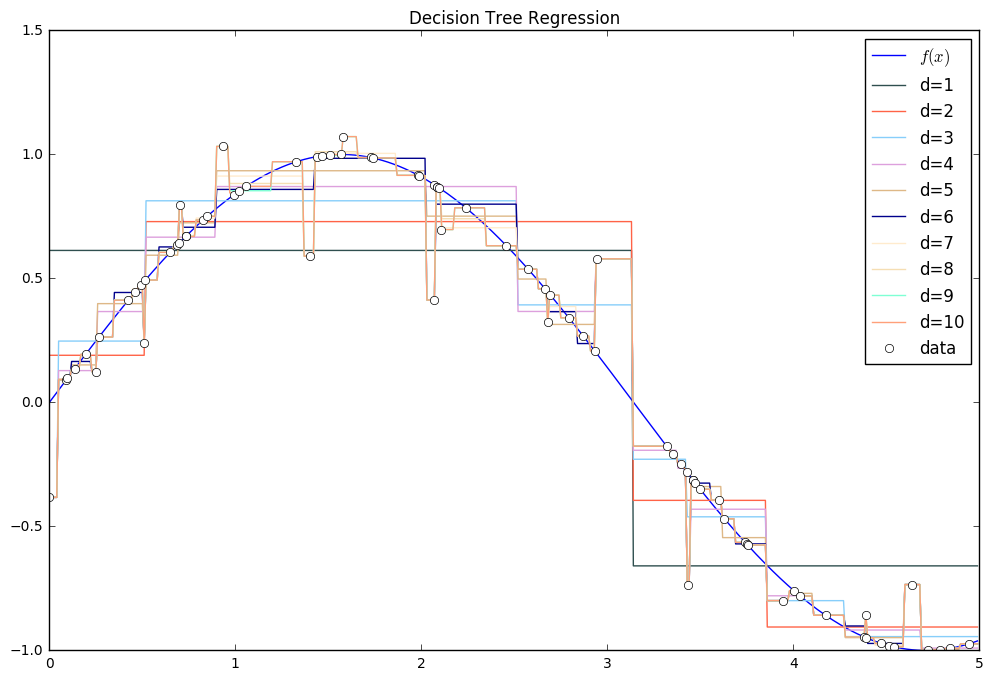

In [4]:
tree = DecisionTreeRegressor(max_depth=tree_max_depth)
tree.fit(X, y)
y_tree = tree.predict(X_test)

plt.figure(figsize=(12, 8))
plt.plot(X_test, np.sin(X_test).ravel(), "b", label="$f(x)$")
for d in range(1, tree_max_depth + 1):
    tree = DecisionTreeRegressor(max_depth=d)
    tree.fit(X, y)
    y_tree = tree.predict(X_test)
    plt.plot(X_test, y_tree, c=colors[d], label="d=" + str(d))

plt.plot(X, y, 'o', c='w', label="data")
plt.title("Decision Tree Regression")
plt.legend(loc=1, numpoints=1)

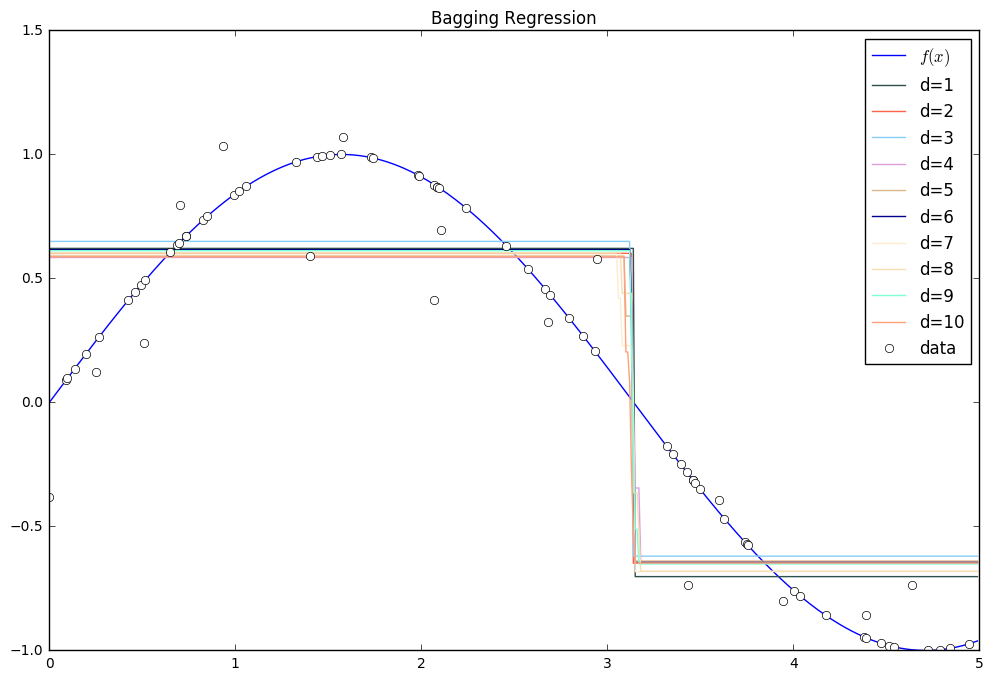

In [5]:
bagging_stump = DecisionTreeRegressor(max_depth=1)
bagging = BaggingRegressor(base_estimator=bagging_stump, n_estimators=n_estimators)

bagging.fit(X, y)
y_bagging = bagging.predict(X_test)

plt.figure(figsize=(12, 8))
plt.plot(X_test, np.sin(X_test).ravel(), "b", label="$f(x)$")
for d in range(1, n_estimators + 1):
    bagging_stump = DecisionTreeRegressor(max_depth=1)
    bagging = BaggingRegressor(bagging_stump, n_estimators=d)
    bagging.fit(X, y)
    y_bagging = bagging.predict(X_test)
    plt.plot(X_test, y_bagging, c=colors[d], label="d=" + str(d))

plt.plot(X, y, 'o', c="w", label="data")
plt.title("Bagging Regression")
plt.legend(loc=1, numpoints=1)

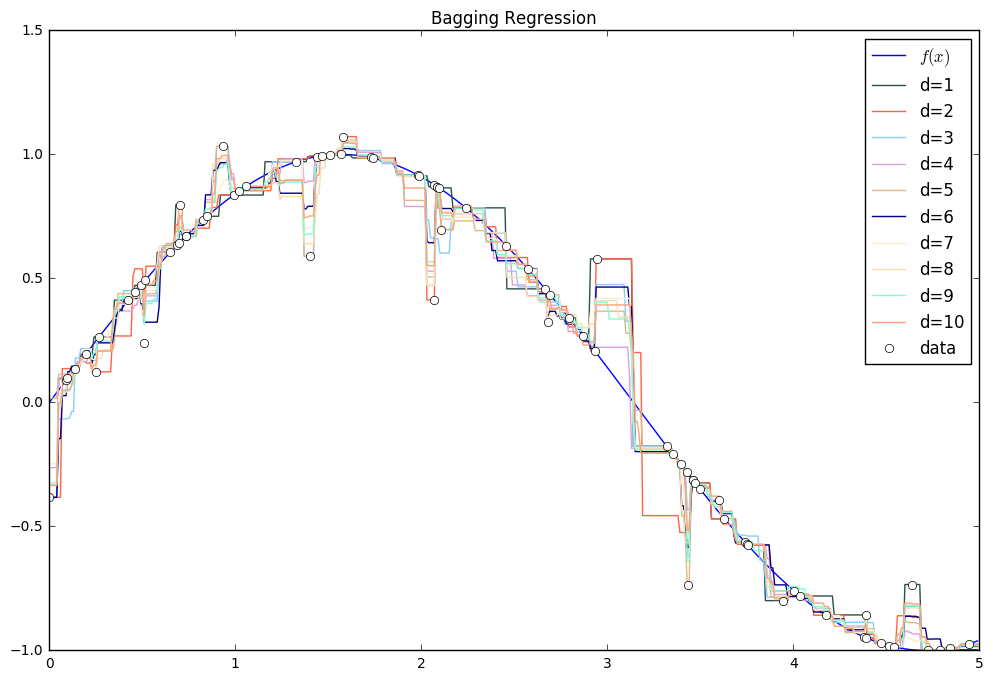

In [6]:
bagging_tree = DecisionTreeRegressor(max_depth=bagging_max_depth)
bagging = BaggingRegressor(bagging_tree, n_estimators=n_estimators)

plt.figure(figsize=(12, 8))
plt.plot(X_test, np.sin(X_test).ravel(), "b", label="$f(x)$")
for d in range(1, n_estimators + 1):
    bagging_stump = DecisionTreeRegressor(max_depth=bagging_max_depth)
    bagging = BaggingRegressor(bagging_stump, n_estimators=d)
    bagging.fit(X, y)
    y_bagging = bagging.predict(X_test)
    plt.plot(X_test, y_bagging, c=colors[d], label="d=" + str(d))

plt.plot(X, y, 'o', c='w', label="data")
plt.title("Bagging Regression")
plt.legend(loc=1, numpoints=1)

### 2) Illustrer graphiquement le rôle de L ainsi que de la profondeur des arbres (max_depth).

On voit que le fait d'augmenter L fait diminuer la variance de l'estimateur


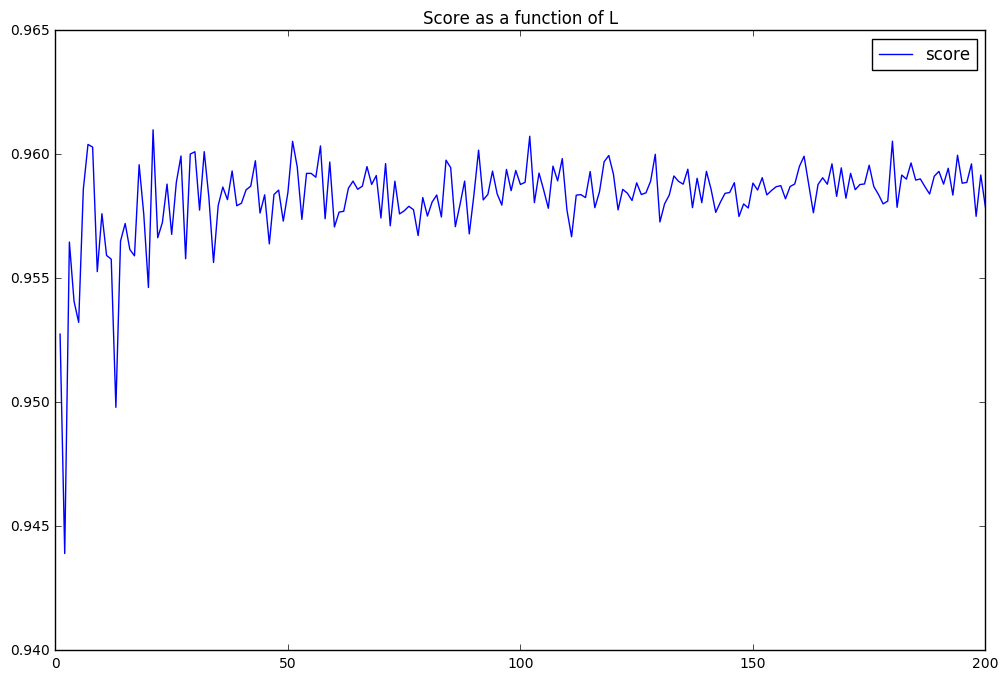

In [7]:
def score_L(L):
    bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=L)
    return bagging.fit(x_tr, y_tr).score(x_te, y_te)

max_L = 200
range_L = list(range(1, max_L+1))
scores = list(map(score_L, range_L))

plt.figure(figsize=(12, 8))
plt.plot(range_L, scores, label='score')
plt.title("Score as a function of L")
plt.legend(loc=1, numpoints=1)

print('On voit que le fait d\'augmenter L fait diminuer la variance de l\'estimateur')

On voit que le fait d'augmenter la profondeur de l'arbre améliore le score jusqu'à un certain seuil, puis stagne. La variance relativement élevée.


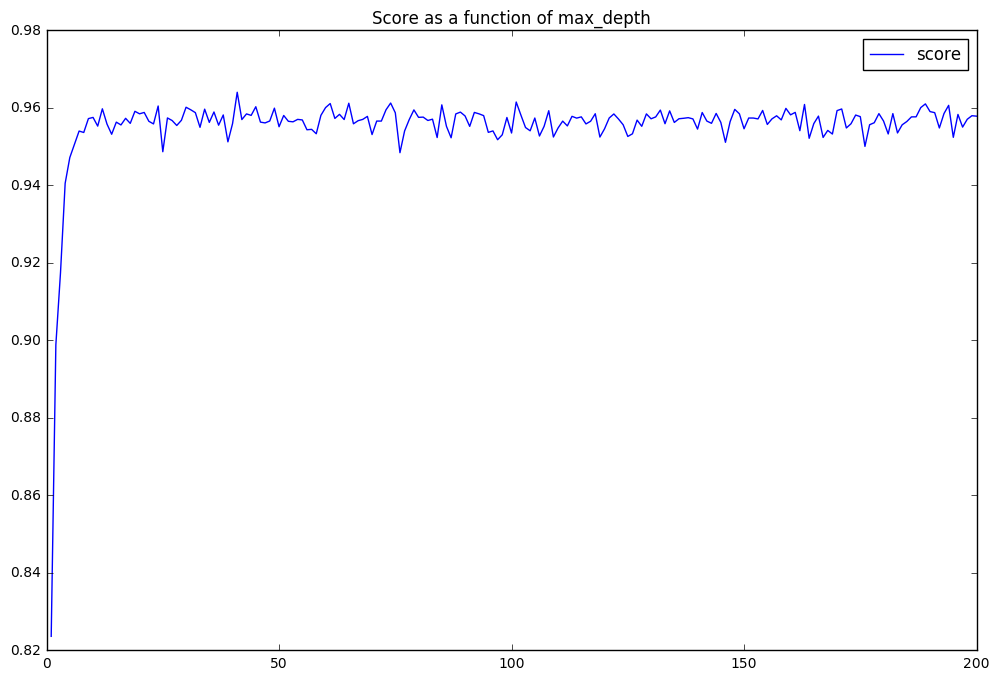

In [8]:
def score_max_depth(max_depth):
    bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth), n_estimators=10)
    return bagging.fit(x_tr, y_tr).score(x_te, y_te)

max_max_depth = 200
range_max_depth = list(range(1, max_max_depth+1))
scores = list(map(score_max_depth, range_max_depth))

plt.figure(figsize=(12, 8))
plt.plot(range_max_depth, scores, c='b', label='score')
plt.title("Score as a function of max_depth")
plt.legend(loc=1, numpoints=1)

print('On voit que le fait d\'augmenter la profondeur de l\'arbre améliore le score jusqu\'à',
     'un certain seuil, puis stagne. La variance relativement élevée.')

### 3) A quoi reconnaît-on que les estimateurs construits par les arbres sont biaisés et que le bagging réduit leur variance ?

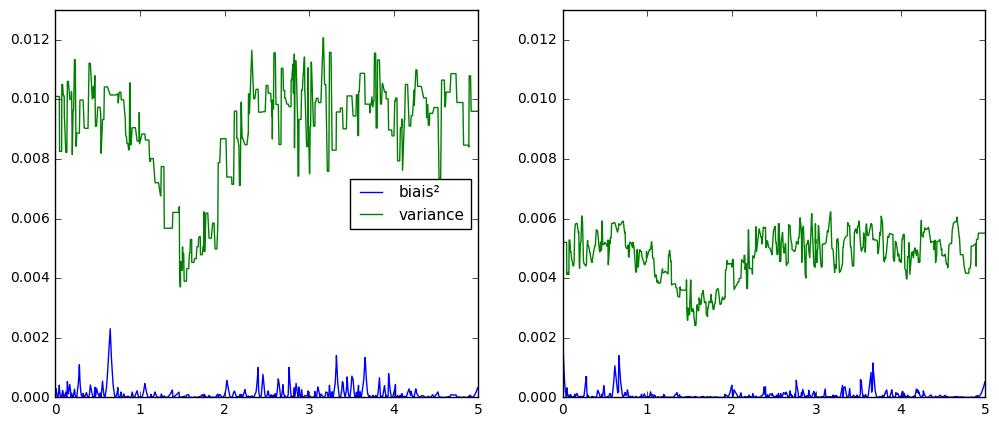

In [9]:
n_repeat = 200   
n_train = 200        
n_test = 1000       
noise = 0.1        
np.random.seed(0)

tree = DecisionTreeRegressor(max_depth=10)
bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=10)

estimators = [("Tree", tree), ("Bagging(Tree)", bagging)]
n_estimators = len(estimators)

# Fonction de génération d'un échantillon bruité
def generate(n_samples, noise, n_repeat=1):
    rng = np.random.RandomState(10)
    X = np.sort(5 * rng.rand(n_samples, 1), axis=0)
    
    if n_repeat == 1:
        y = np.sin(X).ravel() + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        for i in range(n_repeat):
            y[:, i] = np.sin(X).ravel() + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train = []
y_train = []

# Génération de n_repeat échantillons d'entrainement bruités de taille n_train
for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)
    
# Génération de n_test
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(12,5))
plt.xlim([0, 5])
plt.ylim([0, 0.015])

for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)
    
    y_bias = (np.sin(X_test).ravel() - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)
    
    plt.subplot(1, n_estimators, n + 1 )
    plt.plot(X_test, y_bias, 'b', label="biais²")
    plt.plot(X_test, y_var, "g", label="variance")
    plt.ylim([0, 0.013])

    if n == 0:
        plt.legend(loc="best", prop={"size": 11})
plt.show()

### 4) En jouant sur le niveau de bruit mettez en évidence le sur-apprentissage

In [10]:
n_train = 10000
n_test = 2000

noise_range = np.arange(0.01, 5., 0.01)
noise_range_rand = [(n, np.random.randint(0, 9999)) for n in noise_range]

On voit sur la courbe la relation entre la variance du modèle et le niveau de bruit, qui montre le sur-apprentissage


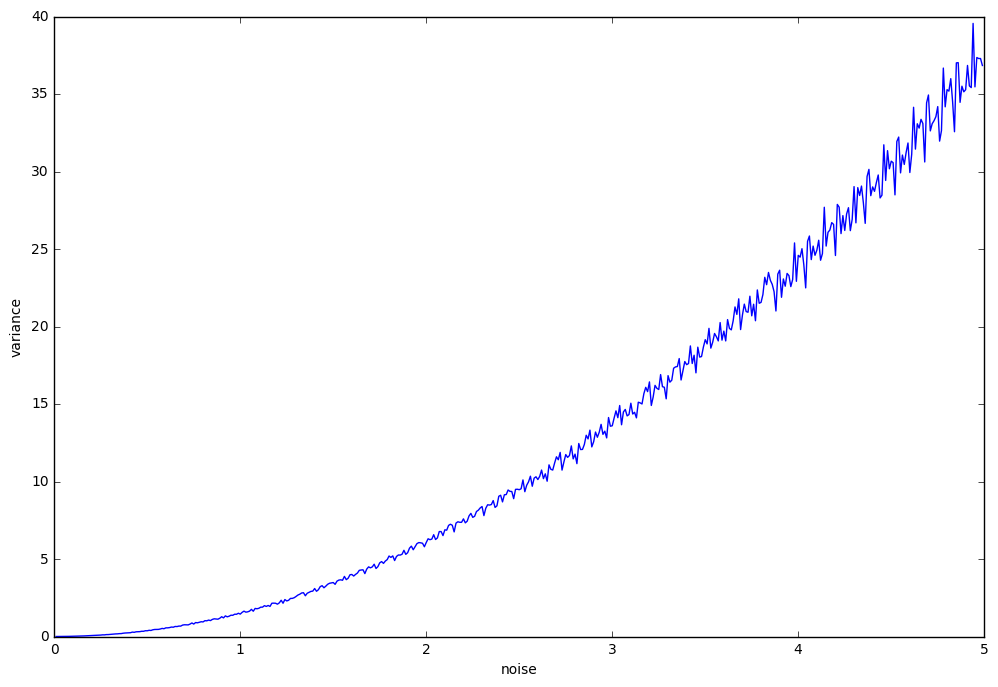

In [11]:
def var_noise(noise_rand):
    noise, rand = noise_rand
    X_train, y_train = generate(n_train, noise)
    X_test, y_test = generate(n_test, noise)
    
    return np.var(BaggingRegressor(
            DecisionTreeRegressor(max_depth=100),
            n_estimators=10,
            random_state=rand
        ).fit(X_train, y_train).predict(X_test) - y_test)

variances_bootstrap_true = Pool().map(var_noise, noise_range_rand)

fig = plt.figure(figsize=(12,8))
plt.plot(noise_range, variances_bootstrap_true)
plt.xlabel('noise')
plt.ylabel('variance')

print('On voit sur la courbe la relation entre la variance du modèle et le niveau de bruit, qui montre le sur-apprentissage')

### 5) Observer qu’on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au lieu de prendre des échantillons bootstrap.

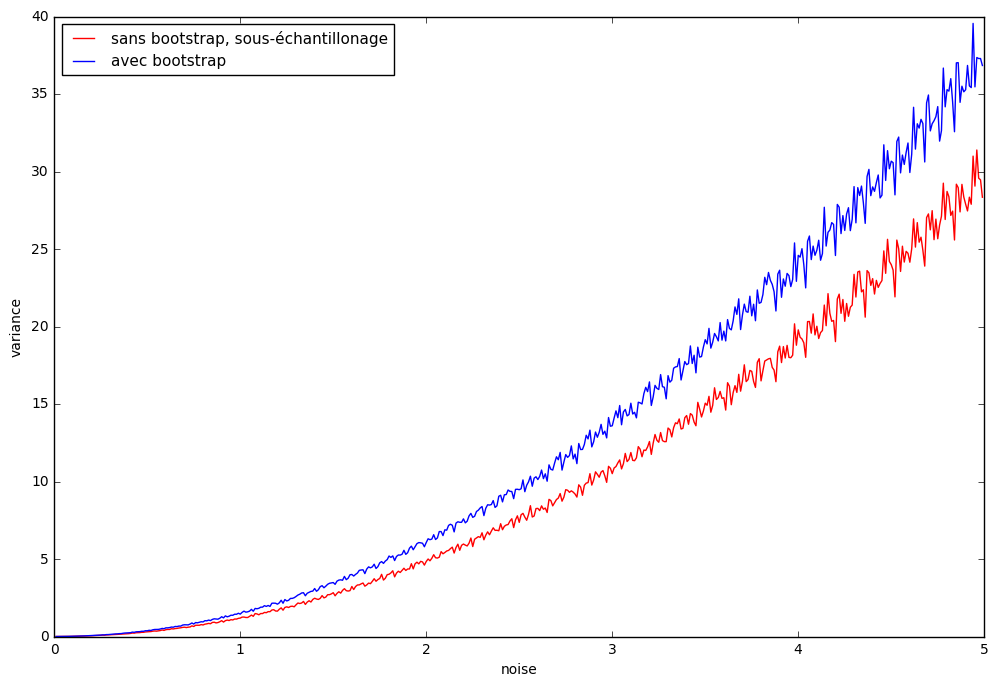

In [12]:
def var_noise_no_boot(noise_rand):
    noise, rand = noise_rand
    X_train, y_train = generate(n_train, noise)
    X_test, y_test = generate(n_test, noise)
    
    return np.var(BaggingRegressor(
            DecisionTreeRegressor(max_depth=100),
            n_estimators=10,
            bootstrap=False,
            max_samples=0.2,
            random_state=9999-rand
        ).fit(X_train, y_train).predict(X_test) - y_test)

variances_bootstrap_false = Pool().map(var_noise_no_boot, noise_range_rand)

plt.figure(figsize=(12,8))
plt.plot(noise_range, variances_bootstrap_false, c='r', label='sans bootstrap, sous-échantillonage')
plt.plot(noise_range, variances_bootstrap_true, c='b', label='avec bootstrap')
plt.xlabel('noise')
plt.ylabel('variance')
plt.legend(loc="best", prop={"size": 11})

## RANDOM FORESTS

### 6) Évaluez le score par 7-fold cross-validation des Random Forests sur les datasets boston, diabetes, iris et digits. Comparez ces performances avec celles d’un SVM linéaire.

In [13]:
def sc(clf, X, y, cv=6, n_jobs=-1):
#     sc = cross_val_score(clf, X, y, cv=cv, n_jobs=n_jobs)
    return np.mean(cross_val_score(clf, X, y, cv=cv, n_jobs=n_jobs)),\
               np.var(cross_val_predict(clf, X, y, cv=cv, n_jobs=-1) - y)

In [14]:
for (name, load_data) in [('iris', load_iris), ('digits', load_digits)]:
    data = load_data()
    X = data.data
    y = data.target
    
    print('Pour le dataset {}:'.format(name))
    sc_rfc, _ = sc(RandomForestClassifier(), X, y, 7)
    print('\tscore RandomForestClassifier => {}'.format(sc_rfc))
    sc_svc, _ = sc(LinearSVC(), X, y, 7)
    print('\tscore LinearSVC => {}'.format(sc_svc))
    print()
    

for (name, load_data) in [('boston', load_boston), ('diabetes', load_diabetes)]:
    data = load_data()
    X = data.data
    y = data.target
    
    print('Pour le dataset {}:'.format(name))
    sc_rfr, _ = sc(RandomForestRegressor(), X, y, 7)
    print('\tscore RandomForestRegressor => {}'.format(sc_rfr))
    sc_svr, _ = sc(LinearSVR(), X, y, 7)
    print('\tscore LinearSVR => {}'.format(sc_svr))
    print()

Pour le dataset iris:
	score RandomForestClassifier => 0.9396258503401361
	score LinearSVC => 0.9591836734693878

Pour le dataset digits:
	score RandomForestClassifier => 0.8980986121345838
	score LinearSVC => 0.9081701575187208

Pour le dataset boston:
	score RandomForestRegressor => 0.6226178356807873
	score LinearSVR => 0.49892419227798296

Pour le dataset diabetes:
	score RandomForestRegressor => 0.3713459601613281
	score LinearSVR => -0.37489981581545173



### 7) En utilisant le dataset iris restreint aux deux premières variables explicatives afficher la probabilité de prédiction des classes. On partira du script suivant et on fera varier le nombre d’arbres aléatoires (variable n_estimators).

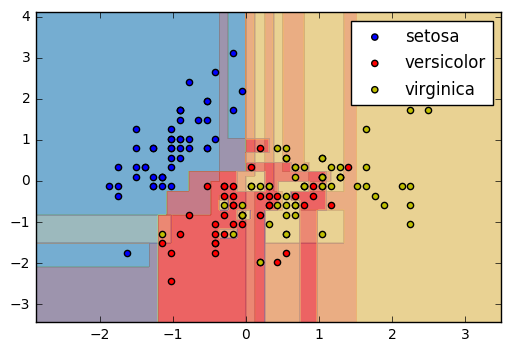

In [15]:
from matplotlib.pyplot import cm

# Parameters
n_estimators = 2
plot_colors = 'bry'
plot_step = 0.02

# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target

# Standardize
X = scale(X_unscaled)

# RF fitting
model = RandomForestClassifier(n_estimators=n_estimators)
clf = model.fit(X, y)

# Plot the decision boundary
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
                     np.arange(x2_min, x2_max, plot_step))

feat_from_meshgrid = np.c_[xx1.ravel(), xx2.ravel()]

plt.figure()

for tree in model.estimators_:
    Z = tree.predict(feat_from_meshgrid).reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Z, alpha=1./n_estimators, cmap=cm.Paired)

plt.axis("tight")

# Plot the training points
for i, c in zip(range(3), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i], cmap=cm.Paired)
plt.legend(scatterpoints=1)
plt.show()

### 8) Comparez les scores par 6-fold cross-validation des Random Forests et des arbres de décisions pures (obtenus avec DecisionTreeClassifier), sur le dataset iris restreint aux deux premières variables explicatives. On fera varier le paramètre max_depth entre 1 et 30. Mettre en évidence le fait que les Random Forests permettent de réduire le sur-apprentissage, et ce même pour des arbres profonds

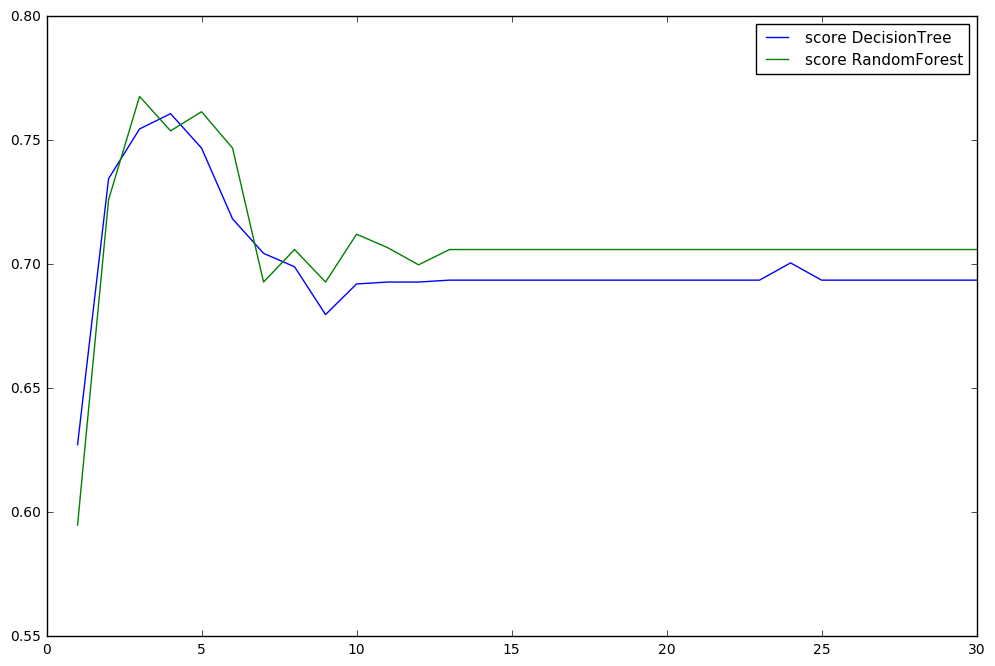

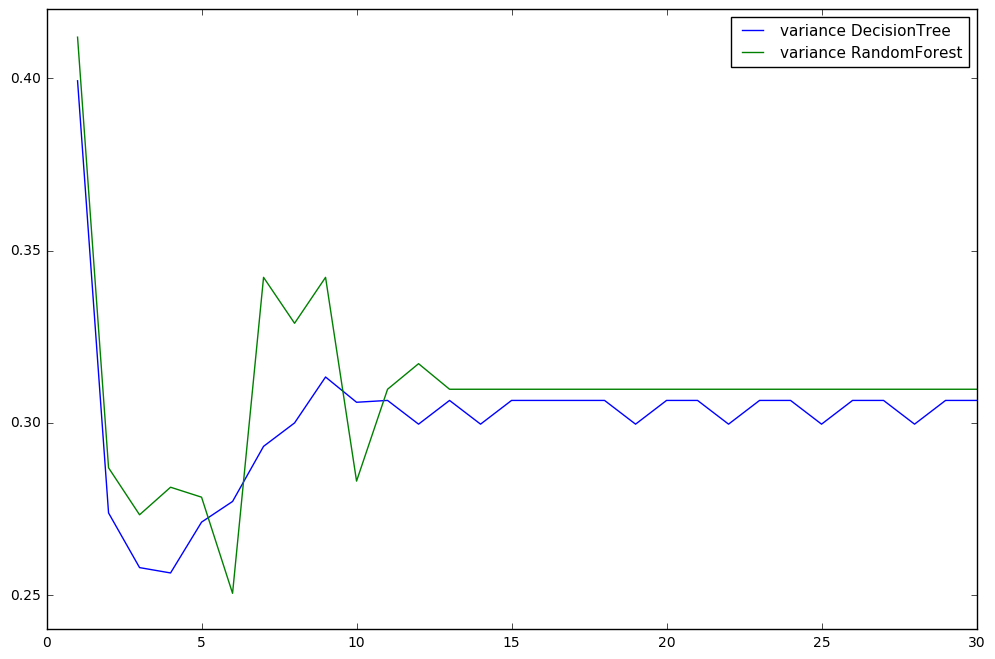

In [16]:
scores_tree = []
scores_rfc = []

# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target

# Standardize
X = scale(X_unscaled)

for max_depth in range(1, 31):
    tree = DecisionTreeClassifier(max_depth=max_depth)
    scores_tree.append(sc(tree, X, y))
    
    rfc = RandomForestClassifier(max_depth=max_depth)
    scores_rfc.append(sc(rfc, X, y))

plt.figure(figsize=(12,8))
plt.plot(range(1,31), [sc[0] for sc in scores_tree], label='score DecisionTree')
plt.plot(range(1,31), [sc[0] for sc in scores_rfc], label='score RandomForest')
plt.legend(loc="best", prop={"size": 11})

plt.figure(figsize=(12,8))
plt.plot(range(1,31), [sc[1] for sc in scores_tree], label='variance DecisionTree')
plt.plot(range(1,31), [sc[1] for sc in scores_rfc], label='variance RandomForest')
plt.legend(loc="best", prop={"size": 11})

### 9) Démontrez la propriété suivante : Le minimiseur de  $f\rightarrow R_{exp}(f) = E\left[e^{−Y.f(x)}\right]$ est $X\rightarrow\dfrac{1}{2}\log\dfrac{\eta(X)}{1−\eta(X)}$

$\mathbb{E}[\;e^{−Y.f(X)}|X]=\mathbb{P}(Y=1\;|\;X).e^{-f(X)}\;+\;\mathbb{P}(Y=-1\;|\;X).e^{f(X)}$$


En dérivant par rapport à f, on résout:$$$$
$\\\\
\dfrac{\partial\mathbb{E}[\;e^{−Y.f(X)}\;|\;X\;]}{\partial f}\;=0\\
\Rightarrow\;-\mathbb{P}(Y=1\;|\;X).e^{-f(X)}\;+\;\mathbb{P}(Y=-1\;|\;X).e^{f(X)}=0\\
\Rightarrow\;f(X)=\dfrac{1}{2}\;log\;\dfrac{\mathbb{P}(Y=1\;|\;X)}{\mathbb{P}(Y=-1\;|\;X)}\\
\Rightarrow\;f(X)=\dfrac{1}{2}\;log\dfrac{\eta(X)}{1-\eta(X)},\;\;avec\;\eta(X)=\mathbb{P}(Y=1\;|\;X)$

### 10) En déduire que le classifieur de Bayes associé au risque $R_{exp}$ est le même que le classifieur de Bayes associé au risque 0/1, $R_{\phi0}$

En étudiant le signe de $\;X\rightarrow2*\eta(X)-1\;$ et de $\;X\rightarrow\dfrac{1}{2}\log\dfrac{\eta(X)}{1-\eta(X)}\;$ on trouve que les classifieurs de Bayes associés à ces fonctions de perte classent identiquement (positionnement par rapport à $\dfrac{1}{2}$).

### 11) Montrer que: $c_m=\underset{c\in\mathbb{R}}{\mathrm{arg min}}\;\mathbb{E}_{\omega^{m−1}}\left[e^{−c·Y·\hat{h}_m(X)}\right]\;=\dfrac{1}{2}\;log\dfrac{\mathbb{P}_{\omega^{m-1}}(Y=\hat{h}_m(X))}{\mathbb{P}_{\omega^{m-1}}(Y \neq \hat{h}_m (X))}$

En utilisant la contrepartie empirique, comme définie dans l'énoncé:$$$$
$\mathbb{E}_{\omega^{m−1}}\left[e^{−c·Y·\hat{h}_m(X)}\right]
=\dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.e^{−c·Y_i·\hat{h}_m(X)}}\\
=\dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i=\hat{h}_m(X_i)}.e^{−c·Y_i·\hat{h}_m(X)}} + \dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i\neq\hat{h}_m(X_i)}.e^{−c·Y_i·\hat{h}_m(X)}}\\
=\dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i=\hat{h}_m(X_i)}.e^{−c}} + \dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i\neq\hat{h}_m(X_i)}.e^{+c}}=Q$$$$$

Comme précédemment, on dérive pour trouver les valeurs de c qui annulent cette quantité:$$$$
$\dfrac{\partial Q}{\partial c}=0
\Leftrightarrow\dfrac{\partial}{\partial c}\left[\dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i=\hat{h}_m(X_i)}.e^{−c}} + \dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i\neq\hat{h}_m(X_i)}.e^{+c}}\right]=0\\
\\\Leftrightarrow-\dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i=\hat{h}_m(X_i)}.e^{−c}} + \dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i\neq\hat{h}_m(X_i)}.e^{+c}}=0
\\\Leftrightarrow e^{2c}=\dfrac{\dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i=\hat{h}_m(X_i)}}}{\dfrac{1}{n}\sum_{i=1}^n{\omega_i^{m-1}.\mathbb{1}_{Y_i\neq\hat{h}_m(X_i)}}}\\\Leftrightarrow c=\dfrac{1}{2}\;log\dfrac{\mathbb{P}_{\omega^{m-1}}(Y=\hat{h}_m(X))}{\mathbb{P}_{\omega^{m-1}}(Y \neq \hat{h}_m (X))}$

### 12) Montrer que les poids $\omega_i^m=\omega_i^{m-1}.e^{-c_m^{\star}.Y_i.\hat{h}_m(X_i)}$ (où $c_m^{\star}$ est défini ci-dessus) et les poids $w_i^m=w_i^{m-1}.e^{2.c_m.\mathbb{1}_{Y_i\neq\hat{h}_m(X_i)}}$ (où $c_m$ est défini dans l'algorithme AdaBoost) sont identiques, avec la convention $\hat{F}_0=0$ et $\omega^0=w^0=(\dfrac{1}{n},\ldots,\dfrac{1}{n}).$

### 13) Mettre en œuvre AdaBoost avec des arbres de profondeur 1, puis 2, puis 10, sur le jeu de données digits. On calculera notamment la précision obtenue par 6-fold cross-validation.

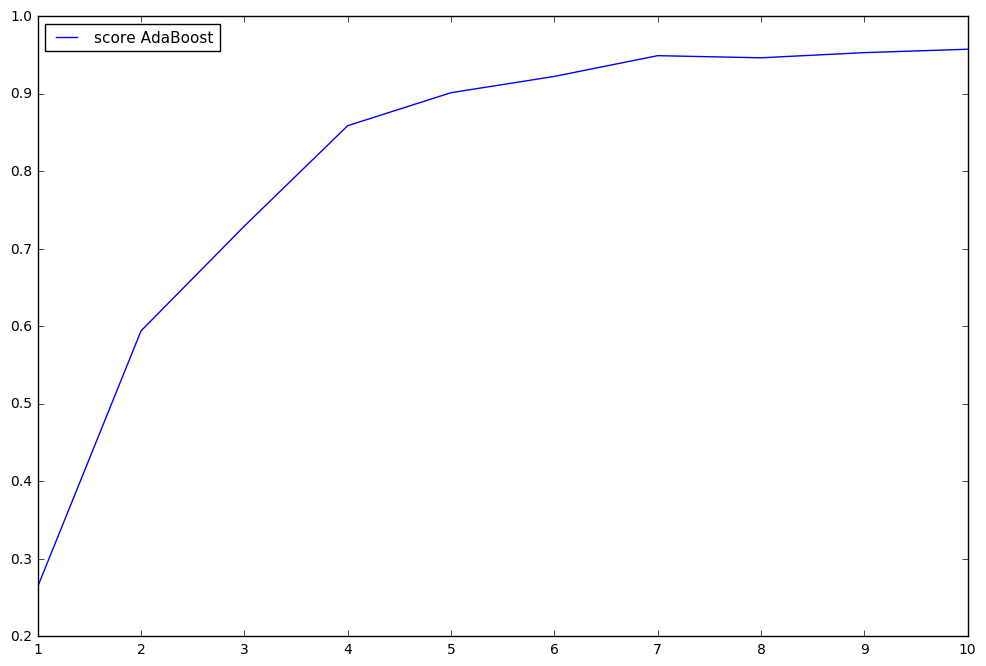

In [17]:
digits = load_digits()
X_unscaled, y = digits.data, digits.target

# Standardize
X = scale(X_unscaled)

scores_ada = []
range_max_depth = range(1, 11)
for d in range_max_depth:
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=d))
    scores_ada.append(sc(ada, X, y)[0])

plt.figure(figsize=(12,8))
plt.plot(range_max_depth, scores_ada, label='score AdaBoost')
plt.legend(loc="best", prop={"size": 11})

### 14) Appliquer AdaBoost sur les données digits découpées en deux échantillons : apprentissage (75%) et test (25%). Tracer les erreurs (0/1) d’apprentissage et de test en fonction du nombre d’itérations.

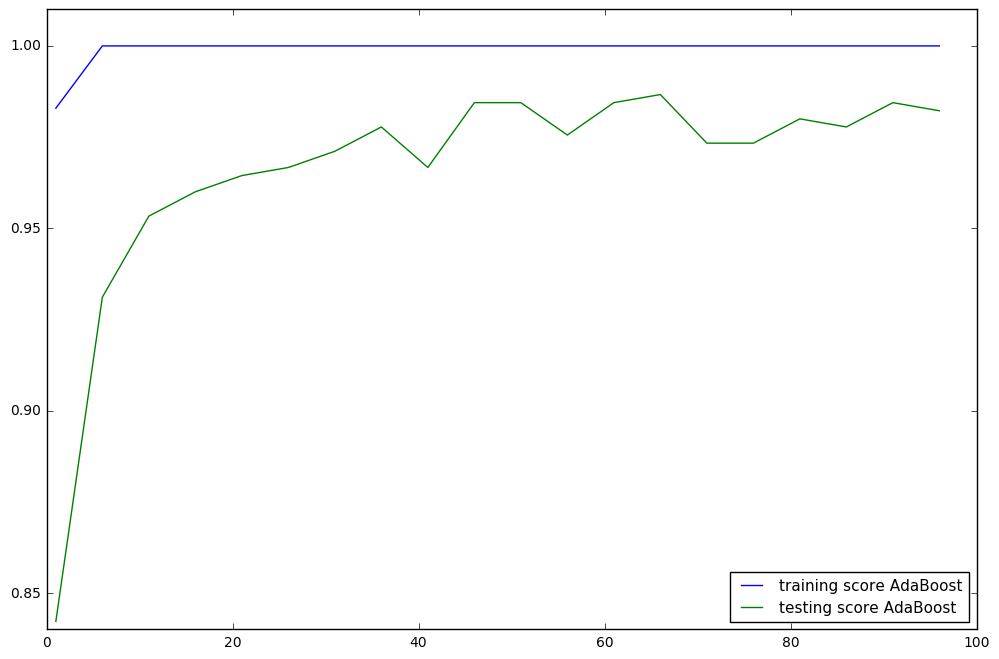

In [18]:
scores_ada_train = []
scores_ada_test = []

range_n_est = range(1, 101, 5)
tree=DecisionTreeClassifier(max_depth=10)

xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.25)

for n_est in range_n_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=n_est).fit(xtr, ytr)
    scores_ada_train.append(ada.score(xtr, ytr))
    scores_ada_test.append(ada.score(xte, yte))

plt.figure(figsize=(12,8))
plt.plot(range_n_est, scores_ada_train, label='training score AdaBoost')
plt.plot(range_n_est, scores_ada_test, label='testing score AdaBoost')
plt.ylim([0.84, 1.01])
plt.legend(loc="best", prop={"size": 11})

### 15) Que remarquez vous ? Que se passe-t-il si la profondeur des arbres de classification est grande ?

On remarque que le score sur le test set augmente rapidement en fonction du nombre d'estimateurs et se stabilise.

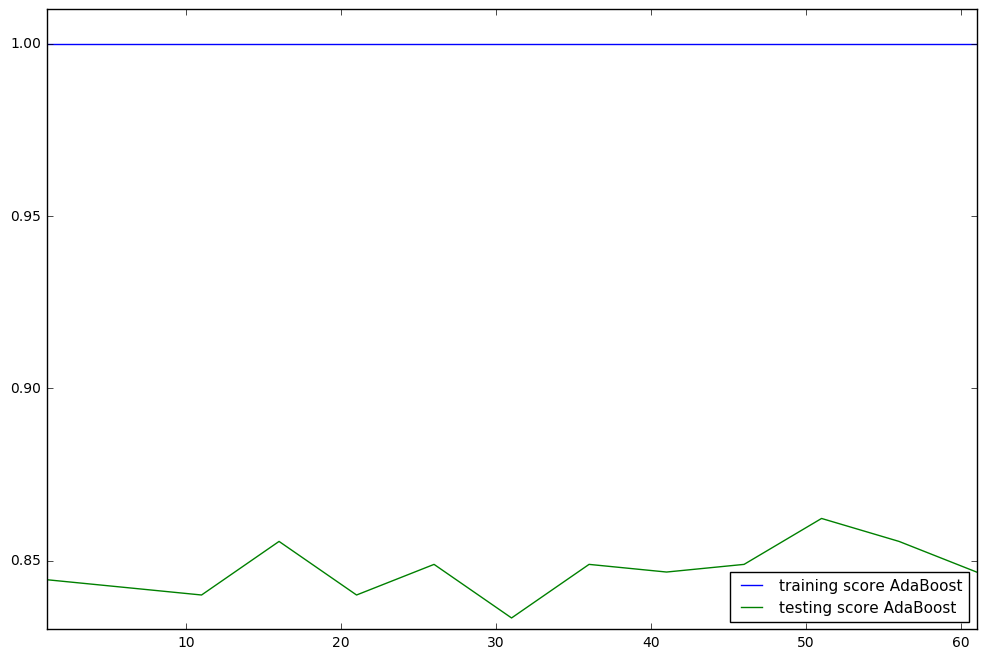

In [19]:
digits = load_digits()
X_unscaled, y = digits.data, digits.target

# Standardize
X = scale(X_unscaled)

scores_ada_train = []
scores_ada_test = []

range_n_est = range(1, 62, 5)
tree=DecisionTreeClassifier(max_depth=30)

xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.25)

for n_est in range_n_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=n_est)
    ada.fit(xtr, ytr)
    scores_ada_train.append(ada.score(xtr, ytr))
    scores_ada_test.append(ada.score(xte, yte))

plt.figure(figsize=(12,8))
plt.plot(range_n_est, scores_ada_train, label='training score AdaBoost')
plt.plot(range_n_est, scores_ada_test, label='testing score AdaBoost')
plt.xlim([1, 61])
plt.ylim([0.83, 1.01])
plt.legend(loc="best", prop={"size": 11})

L'augmentation du nombre d'estimateurs n'apporte pas plus de précision pour la prédiction. En effet, la profondeur des arbres de décisions fait que l'erreur d'apprentissage est nulle dès la première itération (cf ci-dessous). On retrouve alors la prédiction d'un unique DecisionTreeClassifier.

### 16) (Question Bonus) : Implémenter vous-même l’algorithme AdaBoost

In [21]:
class AxelBoostClassifier(ClassifierMixin):
    def __init__(self, base_estimator=None, n_iterations=50):
        self.base_estimator = base_estimator
        self.n_iterations = n_iterations
    
    def fit(self, X, y):
        n = X.shape[0]
        w = np.full((n,), 1/n)
        self.estimators_ = []
        self.cms_ = []
        
        for m in range(self.n_iterations):
            hm = clone(self.base_estimator).fit(X, y, sample_weight=w)
            self.estimators_.append(hm)
            
            pred = hm.predict(X)
            ind_neq = (pred != y)
            p_neq = np.dot(w, ind_neq)
            p_eq = np.dot(w, (pred == y))
            
            if p_neq == 0:
                self.cms_.append(cm)
                break
                
            cm = np.log(p_eq / p_neq)
            self.cms_.append(abs(cm))
            w = np.exp(cm*ind_neq) * w
            w /= np.sum(w)
            
        self.classes_ = self.estimators_[0].classes_
        return self
    
    def predict(self, X):
        return [np.argmax([np.dot(self.cms_, (pred==k)) for k in self.classes_])
                  for pred in np.transpose([est.predict(X) for est in self.estimators_])]

In [22]:
digits = load_digits()
X, y = scale(digits.data), digits.target
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.25)

max_depth = 12

abc = AxelBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth))
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth))
print(np.mean(abc.fit(xtr, ytr).predict(xte) == yte))
print(np.mean(ada.fit(xtr, ytr).predict(xte) == yte))

0.984444444444
0.857777777778
